## Work Flow

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the
provided data for this analysis.
   
2. Build a predictive model to help determine the probability that a rider will
be retained.

3. Evaluate the model.  Focus on metrics that are important for your *statistical
model*.
 
4. Identify / interpret features that are the most influential in affecting
your predictions.

5. Discuss the validity of your model. Issues such as
leakage.  For more on leakage, see [this essay on
Kaggle](https://www.kaggle.com/dansbecker/data-leakage), and this paper: [Leakage in Data
Mining: Formulation, Detection, and Avoidance](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.365.7769&rep=rep1&type=pdf).

6. Repeat 2 - 5 until you have a satisfactory model.

7. Consider business decisions that your model may indicate are appropriate.
Evaluate possible decisions with metrics that are appropriate for *decision
rules*.

## Deliverables

- Code you used to build the model.  The more repeatable, self explanatory, the
  better.

- A presentation including the following points:
  - How did you compute the target?
  - What model did you use in the end? Why?
  - Alternative models you considered? Why are they not good enough?
  - What performance metric did you use to evaluate the *model*? Why?
  - **Based on insights from the model, what plans do you propose to
    reduce churn?**
  - What are the potential impacts of implementing these plans or decisions?
    What performance metrics did you use to evaluate these *decisions*, why?

### Numerical Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

### Learning Libraries

### Load in Data

In [2]:
df = pd.read_csv('../data/churn_train.csv')

#### Convert times (currently in string) to datetimes

In [3]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [4]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


## Problem Description

A ride-sharing company (Company X) is interested in predicting rider retention.
To help explore this question, we have provided a sample dataset of a cohort of
users who signed up for an account in January 2014. The data was pulled on July
1, 2014; we consider a user retained if they were “active” (i.e. took a trip)
in the preceding 30 days (from the day the data was pulled). In other words, a
user is "active" if they have taken a trip since June 1, 2014. The data,
`churn.csv`, is in the [data](data) folder.  The data are split into train and
test sets.  You are encouraged to tune and estimate your model's performance on
the train set, then see how it does on the unseen data in the test set at the
end.

- The 'Feature Importance' discussion is in Random Forests lecture
- Also discussed on page 262 of hands-on

#### A user is "active" if they have taken a trip since June 1, 2014.

In [5]:
cutoff_date = '2014-06-01'
cutoff_date = pd.to_datetime(cutoff_date)

In [6]:
df['churn'] = (df['last_trip_date'] < cutoff_date).astype(int)

In [7]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0,1
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0,1
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0,1
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0,1
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0,1


In [8]:
df['churn'].mean()

0.6242

In [9]:
np.sort(df['avg_rating_of_driver'].unique())

array([1. , 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , nan])

#### Let's look at avg_rating_of_driver = NaN values

In [10]:
df[df['avg_rating_of_driver'].isnull()]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0,1
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0,1
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0,1
5,14.51,5.0,NaN,1.00,Astapor,2014-04-22,iPhone,2014-01-29,0.0,0,True,100.0,1
10,3.96,5.0,NaN,2.00,Winterfell,2014-01-19,iPhone,2014-01-18,100.0,1,False,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39966,8.60,5.0,NaN,1.00,Winterfell,2014-05-26,iPhone,2014-01-31,0.0,0,False,100.0,1
39971,13.45,5.0,NaN,1.00,King's Landing,2014-02-26,Android,2014-01-08,0.0,0,True,100.0,1
39975,1.16,5.0,NaN,1.00,Astapor,2014-01-18,iPhone,2014-01-18,0.0,1,True,0.0,1
39980,4.48,4.0,NaN,1.00,Astapor,2014-05-11,iPhone,2014-01-21,0.0,1,True,50.0,1


In [11]:
df[df['avg_rating_of_driver'].isnull()].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,churn
count,6528.000000,6471.000000,0.0,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000
mean,7.458338,4.783959,NaN,1.079312,8.693474,0.594516,58.917831,0.796109
std,7.778382,0.625550,NaN,0.312519,26.766206,0.609370,46.799590,0.402920
min,0.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.410000,5.000000,NaN,1.000000,0.000000,0.000000,0.000000,1.000000
50%,4.670000,5.000000,NaN,1.000000,0.000000,1.000000,100.000000,1.000000
75%,10.600000,5.000000,NaN,1.000000,0.000000,1.000000,100.000000,1.000000
max,160.960000,5.000000,NaN,5.000000,100.000000,5.000000,100.000000,1.000000


### Make a column, avg_rating_of_driver_nan, where if the rider hasn't given out a rating, then its value is 1

In [12]:
df['avg_rating_of_driver_nan'] = df['avg_rating_of_driver'].isnull().astype(int)

#### Let's look at avg_rating_by_driver = NaN values

In [13]:
df[df['avg_rating_by_driver'].isnull()].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,churn,avg_rating_of_driver_nan
count,162.000000,0.0,105.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,6.337037,NaN,4.509524,1.181049,17.078395,0.567901,53.086420,0.802469,0.351852
std,13.425184,NaN,0.950660,0.492734,37.565520,0.544613,50.059393,0.399371,0.479029
min,0.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.972500,NaN,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.175000,NaN,5.000000,1.000000,0.000000,1.000000,100.000000,1.000000,0.000000
75%,6.430000,NaN,5.000000,1.000000,0.000000,1.000000,100.000000,1.000000,1.000000
max,160.960000,NaN,5.000000,4.000000,100.000000,2.000000,100.000000,1.000000,1.000000


In [14]:
### Make a column, avg_rating_by_driver_nan, where if the rider hasn't been given a rating, then its value is 1

In [15]:
df['avg_rating_by_driver_nan'] = df['avg_rating_by_driver'].isnull().astype(int)

In [16]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,avg_rating_of_driver_nan,avg_rating_by_driver_nan
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0,1,0,0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0,1,0,0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0,1,1,0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0,1,1,0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0,1,1,0


In [17]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,churn,avg_rating_of_driver_nan,avg_rating_by_driver_nan
count,40000.000000,39838.000000,33472.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,5.791302,4.777434,4.601697,1.074956,8.857342,2.280700,60.874382,0.624200,0.163200,0.004050
std,5.708056,0.448088,0.614810,0.222427,20.014008,3.811289,37.089619,0.484335,0.369553,0.063511
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000,0.000000,0.000000,0.000000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000,1.000000,0.000000,0.000000
75%,6.930000,5.000000,5.000000,1.050000,8.300000,3.000000,100.000000,1.000000,0.000000,0.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000,1.000000,1.000000


### What to do with the NaN values? Should we convert those to 0? or Average value in column? Find similar riders?

- It is noted that most get 5 stars, with the mean being above 4.5

### Look at 'phone' column
- Do android vs iphone users have a higher churn?
- What about the nan values?
    - Maybe OHE these?

In [18]:
df['phone'].unique()

array(['Android', 'iPhone', nan], dtype=object)

In [19]:
df['phone'].isnull().sum()

319

### Look at 'city' column
- Should we drop this?
- Or OHE?

In [20]:
df['city'].unique()

array(['Astapor', 'Winterfell', "King's Landing"], dtype=object)

### Plot average of ratings by driver and of driver

/Users/cindywong/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


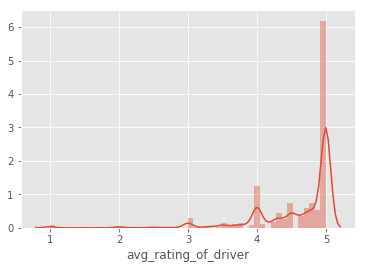

In [92]:
sns.distplot(df['avg_rating_of_driver'].dropna())

/Users/cindywong/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


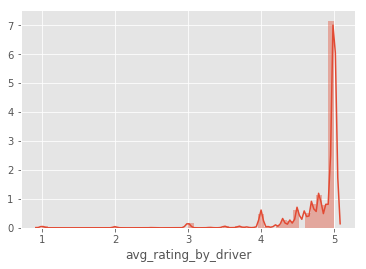

In [86]:
sns.distplot(df['avg_rating_by_driver'].dropna())